In [1]:
import os, shutil

import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
%matplotlib qt

In [2]:
from optv.imgcoord import image_coordinates
from optv.transforms import convert_arr_metric_to_pixel
from optv.orientation import match_detection_to_ref
from optv.segmentation import target_recognition
from optv.orientation import external_calibration, full_calibration
from optv.calibration import Calibration
from optv.tracking_framebuf import TargetArray
from optv.parameters import ControlParams, VolumeParams, TrackingParams, \
    SequenceParams, TargetParams

In [3]:
from pyptv import ptv
from pyptv import parameters as par
from pyptv import parameter_gui as pargui

In [4]:
# set paths:

active_path = '/Users/alex/Documents/OpenPTV/test_cavity/parametersRun1' # like from GUI
print(active_path)
working_folder = os.path.split(active_path)[0]
print(working_folder)
par_path = os.path.join(working_folder, 'parameters')
print(os.path.abspath(par_path))

# set folders, read number of cameras
par.copy_params_dir(active_path, par_path)


/Users/alex/Documents/OpenPTV/test_cavity/parametersRun1
/Users/alex/Documents/OpenPTV/test_cavity
/Users/alex/Documents/OpenPTV/test_cavity/parameters
copy from /Users/alex/Documents/OpenPTV/test_cavity/parametersRun1 to /Users/alex/Documents/OpenPTV/test_cavity/parameters


In [5]:
# read parameters
# first read the number of cameras 
# then read all the parameters, some use liboptv, some use pyptv

os.chdir(os.path.abspath(working_folder))
print("Inside a working folder: ", os.getcwd())

with open(os.path.join(par_path, 'ptv.par'), 'r') as f:
    n_cams = int(f.readline())

print(n_cams)

Inside a working folder:  /Users/alex/Documents/OpenPTV/test_cavity
4


In [6]:
print("Copying man_ori.dat from %s to %s..." % (par_path, working_folder))
try:
    if os.path.isfile(os.path.join(par_path, 'man_ori.dat')):
        shutil.copyfile(os.path.join(par_path, 'man_ori.dat'),
                        os.path.join(working_folder, 'man_ori.dat'))
        print("Copied man_ori.dat \n")
except:
    raise IOError('could not copy man_ori.dat')

Copying man_ori.dat from /Users/alex/Documents/OpenPTV/test_cavity/parameters to /Users/alex/Documents/OpenPTV/test_cavity...
Copied man_ori.dat 



In [7]:
def read_parameters():
    """ reads all the parameters from the /parameters in the working folder"""


    # Control parameters
    cpar = ControlParams(n_cams)
    cpar.read_control_par(b'parameters/ptv.par')

    # Sequence parameters
    spar = SequenceParams(num_cams=n_cams)
    spar.read_sequence_par(b'parameters/sequence.par',n_cams)

    # Volume parameters
    vpar = VolumeParams()
    vpar.read_volume_par(b'parameters/criteria.par')

    # Tracking parameters
    track_par = TrackingParams()
    track_par.read_track_par(b'parameters/track.par')

    # Target parameters
    tpar = TargetParams(n_cams)
    # tpar.read(b'parameters/targ_rec.par') # for all images

    tpar.read(b'parameters/detect_plate.par') # for calibration images


    # Examine parameters, multiplane (single plane vs combined calibration)
    epar= par.ExamineParams()
    epar.read()

    pftVersionParams = par.PftVersionParams(par_path)
    pftVersionParams.read()
    Existing_Target = np.bool(pftVersionParams.Existing_Target)

    calOriParams = par.CalOriParams(n_cams, path=par_path)
    calOriParams.read()

    # Calibration parameters from ORI and ADDPAR files
    cals =[]
    for i_cam in range(n_cams):
        cal = Calibration()
        tmp = cpar.get_cal_img_base_name(i_cam)
        cal.from_file(tmp + b'.ori', tmp + b'.addpar')
        cals.append(cal)

    return cpar, spar, vpar, track_par, tpar, cals, epar, Existing_Target, calOriParams

In [8]:
cpar, spar, vpar, track_par, tpar, cals, epar, Existing_Target, calOriParams = read_parameters()

In [9]:
def rgb2gray(rgb):
    return (0.2989 * rgb[:,:,0] + 0.5870 * rgb[:,:,1] + 0.1140 * rgb[:,:,2]).clip(0,255).astype(np.uint8)

In [10]:
# read calibration images
cal_images = []
for i in range(n_cams):
    imname = cpar.get_cal_img_base_name(i)
    # imname = calParams.img_cal_name[i]
    # for imname in self.calParams.img_cal_name:
    # self.cal_images.append(imread(imname))
    im = imread(imname.decode())
    if im.ndim > 2:
        im = rgb2gray(im)

    cal_images.append(im)

In [11]:
def show_cal_images(ind = None):
    """ Show calibration images, if no inputs, all images are shown by default 
    if input is a scalar - only that image is shown 
    if input is a set of indices, only those cal images are shown
    
    Example:
        show_cal_images()
        show_cal_images(2)
        show_cal_images([0,2])
    """
    if ind is None: # all cameras
        ind = range(n_cams)
    else:
        ind = np.atleast_1d(ind)
        
    if len(ind) > 1:
        fig, ax = plt.subplots(1,len(ind),figsize=(20,12))
        for counter, value in enumerate(ind):
            ax[counter].imshow(cal_images[value],cmap=plt.cm.gray)
    else: # likely a scalar
        fig, ax = plt.subplots(1,1,figsize=(20,12))
        ax.imshow(cal_images[ind[0]],cmap=plt.cm.gray)
        
    plt.show()
    return fig,ax

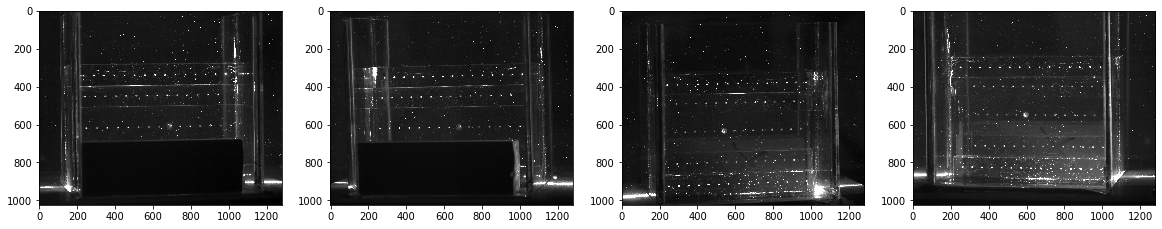

(<Figure size 1440x864 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x130ba8080>,
       dtype=object))

In [12]:
show_cal_images()
# show_cal_images([0,3])
# show_cal_images([2])

In [13]:
from optv.image_processing import preprocess_image

if cpar.get_hp_flag(): # if highpass
    for i in range(n_cams):
        cal_images[i] = preprocess_image(cal_images[i], 0, cpar, 25)
    
    # reset the hp_flag
    cpar.set_hp_flag(False)

In [14]:
print(tpar.get_grey_thresholds())

[40 40 40 40]


In [15]:
from optv.correspondences import correspondences, MatchedCoords
from optv.segmentation import target_recognition


detections, corrected = [],[]
for i_cam, img in enumerate(cal_images):
    
    targs = target_recognition(img, tpar, i_cam, cpar)

    targs.sort_y()
    detections.append(targs)
    mc = MatchedCoords(targs, cpar, cals[i_cam])
    corrected.append(mc)

In [16]:
x = [[i.pos()[0] for i in row] for row in detections]
y = [[i.pos()[1] for i in row] for row in detections]

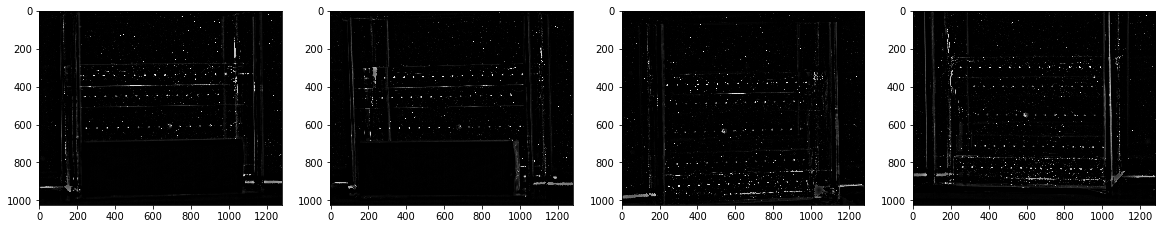

In [17]:
fig,ax = show_cal_images() # show images, overlay with dots
for i in range(n_cams):
    ax[i].scatter(x[i],y[i],marker='+',color='b')

# add initial guess with plot and ipywidget

In [18]:
def read_cal_block():
    # type: () -> numpy.ndarray
    return np.atleast_1d(np.loadtxt(calOriParams.fixp_name, dtype=[('id', 'i4'), ('pos', '3f8')], skiprows=0))

In [19]:
cal_points = read_cal_block()
print(cal_points[0], '...', cal_points[-1])

(1, [-40., -25.,   8.]) ... (73, [30., 25.,  8.])


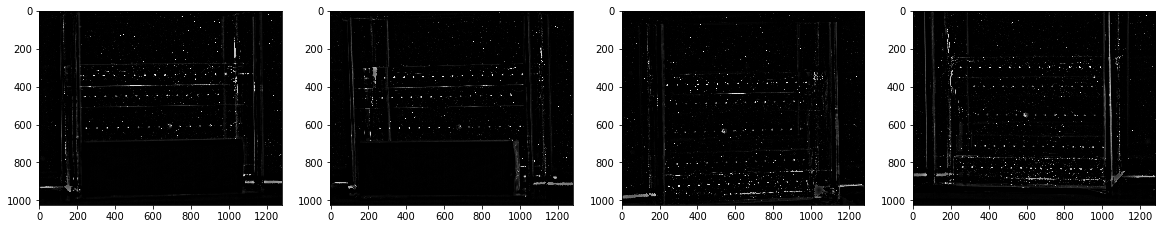

In [20]:
# project initial guess
fig, ax = show_cal_images()

for i_cam in range(n_cams):
    x, y = [], []
    for row in cal_points:
        projected = image_coordinates(np.atleast_2d(row['pos']), \
                                      cals[i_cam], cpar.get_multimedia_params())
        pos = convert_arr_metric_to_pixel(projected, cpar)

        x.append(pos[0][0])
        y.append(pos[0][1])
        
    ax[i_cam].scatter(x,y,marker='+',color='yellow')

In [21]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [22]:
pos0 = cals[0].get_pos()
def initial_guess(i_cam=0, pos = pos0):
    fig, ax = plt.subplots(figsize=(10,10))
    # change the position
    # pos = cals[i_cam].get_pos()
    cals[i_cam].set_pos(pos)
    
    # project and draw
    x, y = [], []
    for row in cal_points:
        projected = image_coordinates(np.atleast_2d(row['pos']), \
                                      cals[i_cam], cpar.get_multimedia_params())
        pos = convert_arr_metric_to_pixel(projected, cpar)

        x.append(pos[0][0])
        y.append(pos[0][1])

    # for i in range(cpar.get_num_cams()):
    ax.imshow(cal_images[i_cam],cmap=plt.cm.gray)
    ax.scatter(x,y,marker='+',color='yellow')
    plt.show()

In [23]:
# interact(initial_guess, i_cam=0, pos=cals[0].get_pos())

In [24]:
# sortgrid

In [25]:
def edit_cal_parameters():
    cp = pargui.Calib_Params(par_path=par_path)
    cp.edit_traits(kind='modal')
    
    # at the end of a modification, copy the parameters
    par.copy_params_dir(par_path, active_path)

In [26]:
edit_cal_parameters()

# must read again the parameters
cpar, spar, vpar, track_par, tpar, cals, epar, Existing_Target,\
                            calOriParams = read_parameters()

calOriParams.fixp_name # test

inside CalHandler  /Users/alex/Documents/OpenPTV/test_cavity/parameters
copy from /Users/alex/Documents/OpenPTV/test_cavity/parameters to /Users/alex/Documents/OpenPTV/test_cavity/parametersRun1


'cal/target_on_a_side.txt'

In [27]:
def _button_showimg_fired(self):

    print("Loading images/parameters \n")

    # Initialize what is needed, copy necessary things



    # copy parameters from active to default folder parameters/
    par.copy_params_dir(self.active_path, self.par_path)

    # read from parameters
    self.cpar, self.spar, self.vpar, self.track_par, self.tpar, \
    self.cals, self.epar = ptv.py_start_proc_c(self.n_cams)

    self.tpar.read(b'parameters/detect_plate.par')

    print(self.tpar.get_grey_thresholds())


    self.calParams = par.CalOriParams(self.n_cams, self.par_path)
    self.calParams.read()

    if self.epar.Combine_Flag is True : 
        print("Combine Flag")
        self.MultiParams = par.MultiPlaneParams()
        self.MultiParams.read()
        for i in range(self.MultiParams.n_planes):
            print(self.MultiParams.plane_name[i])

        self.pass_raw_orient = True
        self.status_text = "Multiplane calibration."



    self.reset_show_images()



    self.pass_init = True
    self.status_text = "Initialization finished."

In [28]:
# not implemented - need to add a function that allows
# to click 4 points on every image to get the manual orientation
# the points are written in the man_ori array, see above
# the points in pixels are stored in man_ori.dat file that
# should appear in the working_folder and later copied to the 
# parameters folder active_path for the future 

def _button_manual_fired(self):
    points_set = True
    for i in range(self.n_cams):
        if len(self.camera[i]._x) < 4:
            print("inside manual click")
            print(self.camera[i]._x)
            points_set = False

    if points_set:
        man_ori_path = os.path.join(os.getcwd(), 'man_ori.dat')
        f = open(man_ori_path, 'w')
        if f is None:
            self.status_text = "Error saving man_ori.dat."
        else:
            for i in range(self.n_cams):
                for j in range(4):
                    f.write("%f %f\n" %
                            (self.camera[i]._x[j], self.camera[i]._y[j]))

            self.status_text = "man_ori.dat saved."
            f.close()
    else:
        self.status_text = "Set 4 points on each calibration image for manual orientation"

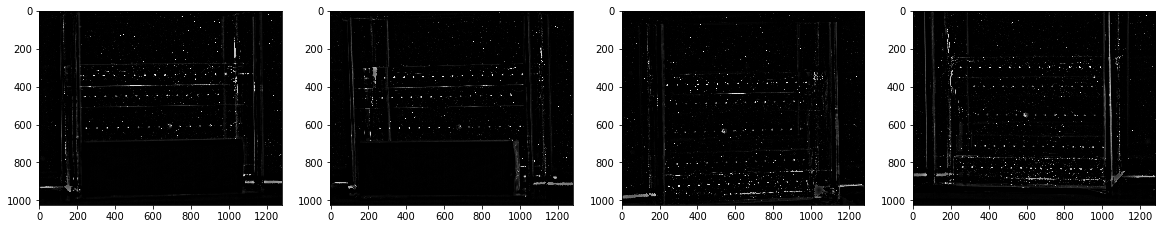

'/Users/alex/Documents/OpenPTV/test_cavity/parametersRun1/man_ori.dat'

In [29]:
# orientation with file 
# load the dots that are stored in the man_ori.dat (pixels)
# and their indices from the man_ori.par (index according to the calibration block text file)
# and plots over the image
man_ori_par = np.loadtxt(os.path.join(par_path, 'man_ori.par')).reshape((n_cams,-1)).astype(np.int)
man_ori_dat = np.loadtxt(os.path.join(working_folder, 'man_ori.dat')).reshape((n_cams,-1))

fig, ax = show_cal_images()
for i in range(n_cams):
    for j in range(4):
        ax[i].scatter(man_ori_dat[i][j*2],man_ori_dat[i][j*2+1],color='y',marker='x')
        ax[i].annotate(str(man_ori_par[i][j]),(man_ori_dat[i][j*2],man_ori_dat[i][j*2+1]),color='r')

# backup to the parameters folder 
shutil.copyfile(os.path.join(working_folder, 'man_ori.dat'), os.path.join(active_path, 'man_ori.dat'))

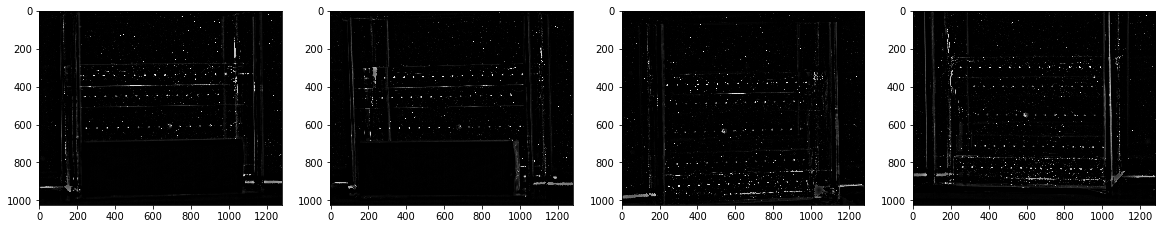

In [30]:
fig, ax = show_cal_images()

sorted_targs = []

for i_cam in range(n_cams):

    # if len(self.cal_points) > len(self.detections[i_cam]):
    #     raise ValueError("Insufficient detected points, need at least as"
    #                  "many as fixed points")

    targs = match_detection_to_ref(cals[i_cam], cal_points['pos'],
                                   detections[i_cam], cpar)
    x, y, pnr = [], [], []
    for t in targs:
        if t.pnr() != -999:
            # pnr.append(cal_points['id'][t.pnr()])
            # x.append(t.pos()[0])
            # y.append(t.pos()[1])
            ax[i_cam].scatter(t.pos()[0], t.pos()[1],1,color='yellow')
            ax[i_cam].annotate(str(cal_points['id'][t.pnr()]),(t.pos()[0],t.pos()[1]),color='r')

    sorted_targs.append(targs)
    # ax[i_cam].plot_num_overlay(x, y, pnr) # <-- implement this one text over image
    # ax[i_cam].scatter(x,y,1,color='yellow')
    

In [31]:
def plot_num_overlay(self, x, y, txt):
    for i in range(len(x)):
        coord_x, coord_y = self._plot.map_screen([(x[i], y[i])])[0]
        ovlay = TextBoxOverlay(component=self._plot,
                               text=str(txt[i]), alternate_position=(coord_x, coord_y),
                               real_position=(x[i], y[i]),
                               text_color="white",
                               border_color="red"
                               )
        self._plot.overlays.append(ovlay)

In [32]:
def raw_orient():
    """
    update the external calibration with results of raw orientation, i.e.
    the iterative process that adjust the initial guess' external
    parameters (position and angle of cameras) without internal or
    distortions.

    See: https://github.com/openptv/openptv/liboptv/src/orientation.c#L591
    """
    if self.need_reset:
        self.reset_show_images()
        self.need_reset = 0

    # backup the ORI/ADDPAR files first
    self.backup_ori_files()

    # get manual points from cal_points and use ids from man_ori.par

    for i_cam in range(self.n_cams):
        selected_points = np.zeros((4, 3))
        for i, cp_id in enumerate(self.cal_points['id']):
            for j in range(4):
                if cp_id == self.camera[i_cam].man_ori[j]:
                    selected_points[j, :] = self.cal_points['pos'][i, :]
                    continue

        # in pixels:
        manual_detection_points = np.array((self.camera[i_cam]._x, self.camera[i_cam]._y)).T

        success = external_calibration(self.cals[i_cam], selected_points, \
                                       manual_detection_points, self.cpar)

        if success is False:
            print("Initial guess has not been successful\n")
        else:
            self.camera[i_cam]._plot.overlays = []
            self._project_cal_points(i_cam, color="red")
            self._write_ori(i_cam)

    self.status_text = "Orientation finished"
    self.pass_raw_orient = True

In [33]:
def fine_orient():
    """
    fine tuning of ORI and ADDPAR

    """
    scale = 5000

    if self.need_reset:
        self.reset_show_images()
        self.need_reset = 0

    # backup the ORI/ADDPAR files first
    self.backup_ori_files()

    op = par.OrientParams()
    op.read()

    # recognized names for the flags:
    names = ['cc', 'xh', 'yh', 'k1', 'k2', 'k3', 'p1', 'p2', 'scale', 'shear']
    op_names = [op.cc, op.xh, op.yh, op.k1, op.k2, op.k3, op.p1, op.p2, op.scale, op.shear]

    flags = []
    for name, op_name in zip(names, op_names):
        if (op_name == 1):
            flags.append(name)




    for i_cam in range(self.n_cams): # iterate over all cameras

        if self.epar.Combine_Flag:

            self.status_text = "Multiplane calibration."
            """ Performs multiplane calibration, in which for all cameras the 
            pre-processed planes in multi_plane.par combined.
            Overwrites the ori and addpar files of the cameras specified 
            in cal_ori.par of the multiplane parameter folder
            """

            all_known = []
            all_detected = []

            for i in range(self.MultiParams.n_planes): # combine all single planes

                # c = self.calParams.img_ori[i_cam][-9] # Get camera id
                c = re.findall('\\d+',self.calParams.img_ori[i_cam])[0] # not all ends with a number

                file_known = self.MultiParams.plane_name[i]+c+'.tif.fix'
                file_detected = self.MultiParams.plane_name[i]+c+'.tif.crd'

                # Load calibration point information from plane i
                try:
                    known = np.loadtxt(file_known)
                    detected = np.loadtxt(file_detected)
                except:
                    raise IOError("reading {} or {} failed".format(file_known,file_detected))


                if np.any(detected == -999):
                    raise ValueError(("Using undetected points in {} will cause " +
                    "silliness. Quitting.").format(file_detected))

                num_known = len(known)
                num_detect = len(detected)

                if num_known != num_detect:
                    raise ValueError("Number of detected points (%d) does not match" +\
                    " number of known points (%d) for %s, %s" % \
                    (num_known, num_detect, file_known, file_detected))

                if len(all_known) > 0:
                    detected[:,0] = all_detected[-1][-1,0] + 1 + np.arange(len(detected))

                # Append to list of total known and detected points
                all_known.append(known)
                all_detected.append(detected)


            # Make into the format needed for full_calibration.
            all_known = np.vstack(all_known)[:,1:]
            all_detected = np.vstack(all_detected)

            # this is the main difference in the multiplane mode
            # that we fill the targs and cal_points by the 
            # combined information

            targs = TargetArray(len(all_detected))
            for tix in range(len(all_detected)):
                targ = targs[tix]
                det = all_detected[tix]

                targ.set_pnr(tix)
                targ.set_pos(det[1:])

            self.cal_points = np.empty((all_known.shape[0],)).astype(dtype=[('id', 'i4'), ('pos', '3f8')])
            self.cal_points['pos'] = all_known
        else:
            targs = self.sorted_targs[i_cam]

        try: 
            residuals, targ_ix, err_est = full_calibration(self.cals[i_cam], self.cal_points['pos'], \
                                                       targs, self.cpar, flags)
        except:
            raise ValueError("full calibration failed\n")
        # save the results
        self._write_ori(i_cam)


        # Plot the output
        # self.reset_plots()

        x, y = [], []
        for r, t in zip(residuals, targ_ix):
            if t != -999:
                pos = targs[t].pos()
                x.append(pos[0])
                y.append(pos[1])

        self.camera[i_cam]._plot.overlays = []
        self.drawcross("orient_x", "orient_y", x, y, 'orange', 5, i_cam=i_cam)

        # self.camera[i]._plot_data.set_data(
        #     'imagedata', self.ori_img[i].astype(np.float))
        # self.camera[i]._img_plot = self.camera[
        #     i]._plot.img_plot('imagedata', colormap=gray)[0]
        self.camera[i_cam].drawquiver(x, y, x+scale*residuals[:len(x),0], y+scale*residuals[:len(x),1], "red")
        # self.camera[i]._plot.index_mapper.range.set_bounds(0, self.h_pixel)
        # self.camera[i]._plot.value_mapper.range.set_bounds(0, self.v_pixel)

    self.status_text = "Orientation finished."

In [34]:
def write_ori(i_cam):
    """ Writes ORI and ADDPAR files for a single calibration result
    """
    ori = calParams.img_ori[i_cam]
    addpar = ori.replace('ori', 'addpar')
    print("Saving:", ori, addpar)
    cals[i_cam].write(ori.encode(), addpar.encode())
    if epar.Examine_Flag and not epar.Combine_Flag:
        save_point_sets(i_cam)

In [35]:
def save_point_sets(self, i_cam):
    """
    Saves detected and known calibration points in crd and fix format, respectively.
    These files are needed for multiplane calibration.
    """

    ori = self.calParams.img_ori[i_cam]
    txt_detected = ori.replace('ori', 'crd')
    txt_matched = ori.replace('ori', 'fix')


    detected, known = [],[]
    targs = self.sorted_targs[i_cam]
    for i,t in enumerate(targs):
        if t.pnr() != -999:
            detected.append(t.pos())
            known.append(self.cal_points['pos'][i]) 
    nums = np.arange(len(detected))
    # for pnr in nums:
    #     print(targs[pnr].pnr())
    #     print(targs[pnr].pos())
    #   detected[pnr] = targs[pnr].pos()

    detected = np.hstack((nums[:,None], np.array(detected)))
    known = np.hstack((nums[:,None], np.array(known)))

    np.savetxt(txt_detected, detected, fmt="%9.5f")
    np.savetxt(txt_matched, known, fmt="%10.5f")

In [36]:
def orient():

    # backup ori files
    backup_ori_files()
    
    # calibration
    ptv.py_calibration(10)
    
    # get the output from the orientation
    x1, y1, x2, y2 = [], [], [], []
    ptv.py_get_from_orient(x1, y1, x2, y2)

    for i in range(n_cams):
        ax.imshow(ori_img[i],cmap=plt.cm.gray)
        ax.drawquiver(x1[i], y1[i], x2[i], y2[i], "red")
        ax.scatter(x1, y1, color="orange", size=4)

In [37]:
def _button_edit_ori_files_fired(self):
    editor = codeEditor(path=self.par_path)
    editor.edit_traits(kind='livemodal')

In [38]:
import shutil
def backup_ori_files():
    # backup ORI files
    for f in calOriParams.img_ori[:n_cams]:
        shutil.copyfile(f, f + '.bck')
        g = f.replace('ori', 'addpar')
        shutil.copyfile(g, g + '.bck')

In [39]:
# protect ORI files
for f in calOriParams.img_ori[:n_cams]:
    with open(f, 'r') as d:
        d.read().split()
        if not np.all(np.isfinite(np.asarray(d).astype('f'))):  # if there NaN for instance
            print("protected ORI file %s " % f)
            shutil.copyfile(f + '.bck', f)


TypeError: float() argument must be a string or a number, not '_io.TextIOWrapper'

In [ ]:
# restore ori files
def restore_ori_files(n_cams, calOriParams):
    for f in calOriParams.img_ori[:n_cams]:
        print('restored %s ' % f)
        shutil.copyfile(f + '.bck', f)
        g = f.replace('ori', 'addpar')
        shutil.copyfile(g + '.bck', g)

In [ ]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(m, b):
    plt.figure(2)
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.show()

interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

In [ ]:
from ipywidgets import FloatSlider
x_widget = FloatSlider(min=0.0, max=10.0, step=0.05)
y_widget = FloatSlider(min=0.5, max=10.0, step=0.05, value=5.0)

def update_x_range(*args):
    x_widget.max = 2.0 * y_widget.value
y_widget.observe(update_x_range, 'value')

def printer(x, y):
    print(x, y)
interact(printer,x=x_widget, y=y_widget);

In [1]:
def tellme(s):
    print(s)
    plt.title(s, fontsize=16)
    plt.draw()

In [ ]:
plt.clf()
plt.setp(plt.gca(), autoscale_on=False)

tellme('You will define a triangle, click to begin')

plt.waitforbuttonpress()

while True:
    pts = []
    while len(pts) < 3:
        tellme('Select 3 corners with mouse')
        pts = np.asarray(plt.ginput(3, timeout=-1))
        if len(pts) < 3:
            tellme('Too few points, starting over')
            time.sleep(1)  # Wait a second

    ph = plt.fill(pts[:, 0], pts[:, 1], 'r', lw=2)

    tellme('Happy? Key click for yes, mouse click for no')

    if plt.waitforbuttonpress():
        break

    # Get rid of fill
    for p in ph:
        p.remove()